Marcin Wardyński  
czwartek, 8:00

In [2]:
import neural_utils as utils

corpus, queries, qrels = utils.load_fiqa()
all_docs = corpus['corpus']

test_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['test'])
test_queries_dict = utils.prepare_fiqa_queries_for_selected_subset(queries, test_query_to_corpus_dict)

In [3]:
from haystack.document_stores.types import DuplicatePolicy
from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

from haystack_integrations.document_stores.qdrant import QdrantDocumentStore


def load_docs_into_data_store(document_store, all_docs, model):
    documents = [Document(id=doc['_id'], content=doc['text']) for doc in all_docs]
    
    document_embedder = SentenceTransformersDocumentEmbedder(model=model)  
    document_embedder.warm_up()
    documents_with_embeddings = document_embedder.run(documents)

    document_store.write_documents(documents_with_embeddings.get("documents"), policy=DuplicatePolicy.OVERWRITE)

In [4]:
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever

from haystack.components.classifiers import TransformersZeroShotDocumentClassifier

def build_query_pipeline(document_store, model, top_k):
    retriever = QdrantEmbeddingRetriever(document_store=document_store, top_k=top_k)

    query_pipeline = Pipeline()
    query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model=model))
    query_pipeline.add_component("retriever", retriever)
    query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

    return query_pipeline

def query_data_store(query_pipeline, query, n):
    result = query_pipeline.run({"text_embedder": {"text": query}})
    return result['retriever']['documents'][:n]


In [10]:

model = "sdadas/mmlw-retrieval-roberta-base"

document_store = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
)

load_docs_into_data_store(document_store, all_docs, model)

Batches: 100%|██████████| 1802/1802 [30:58<00:00,  1.03s/it]
57700it [01:11, 806.30it/s]                           


In [49]:
model = "sdadas/mmlw-retrieval-roberta-base"

top_k = 5
query_pipeline = build_query_pipeline(document_store, model, top_k)

ndcgs_size = 5
ndcgs = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline, query_data_store, ndcgs_size)

Batches: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


Czas: 3:28

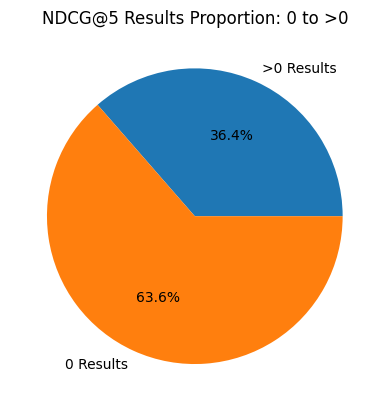

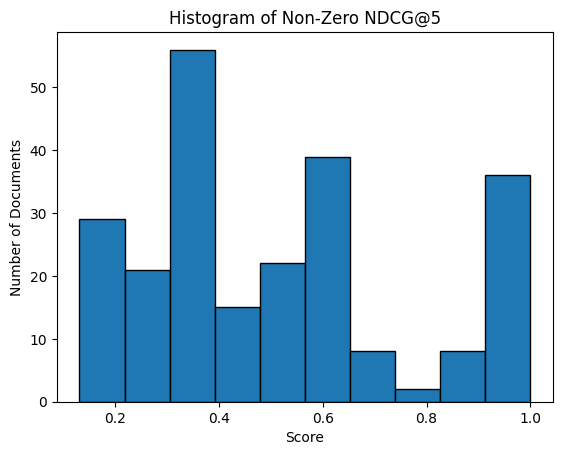

NDCG@5 Mean: 0.18988865853627918 and Std: 0.29692386698863327
NDCG@5 > 0 Mean: 0.5213891980148683 and Std: 0.2631273967008143


In [51]:
utils.present_results(ndcgs)

In [5]:
model = "intfloat/e5-base"

document_store_e5 = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
    similarity="cosine",
    embedding_dim=768
)

load_docs_into_data_store(document_store_e5, all_docs, model)

Batches: 100%|██████████| 1802/1802 [28:31<00:00,  1.05it/s]
57700it [01:12, 797.52it/s]                           


In [15]:
model = "intfloat/e5-base"

top_k = 5
query_pipeline_e5 = build_query_pipeline(document_store_e5, model, top_k)

ndcgs_size = 5
ndcgs_e5 = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline_e5, query_data_store, ndcgs_size)

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Czas: 3:45

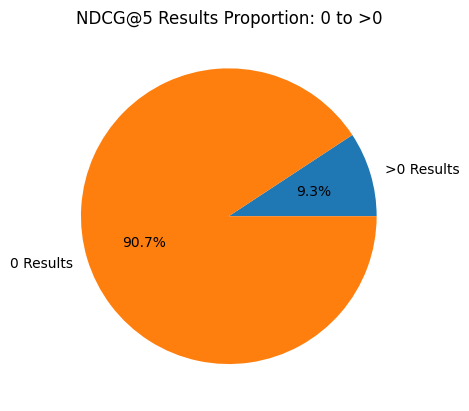

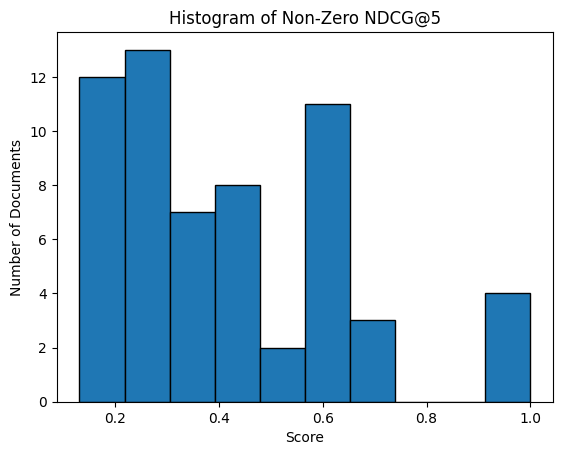

NDCG@5 Mean: 0.03941151967660224 and Std: 0.14087059341817887
NDCG@5 > 0 Mean: 0.42564441250730417 and Std: 0.22343452600699337


In [16]:
utils.present_results(ndcgs_e5)

In [26]:
from transformers import AutoModelForSequenceClassification

class_model = "./best_model_f1_rand"

model = AutoModelForSequenceClassification.from_pretrained(class_model)

model.config.label2id = {"contradiction": 0, "entailment": 1}
model.config.id2label = {0: "contradiction", 1: "entailment"}
model.save_pretrained(class_model)

In [52]:
from typing import List
from haystack import component

@component
class QACombiner:

    @component.output_types(documents=List[Document])
    def run(self, query:str, documents:List[Document]):
        separator = "</s>"

        documents_out = [Document(id = document.id, content = f"{query}{separator}{document.content}") for document in documents]

        return {"documents": documents_out}

In [59]:
def build_query_pipeline_with_classification(document_store, ret_model, class_model, top_k):
    retriever = QdrantEmbeddingRetriever(document_store=document_store, top_k=top_k)
    classifier = TransformersZeroShotDocumentClassifier(model=class_model, labels=["contradiction", "entailment"])
    classifier.warm_up()
    qa_combiner = QACombiner()

    query_pipeline = Pipeline()
    query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model=ret_model))
    query_pipeline.add_component("retriever", retriever)
    query_pipeline.add_component("qa_combiner", qa_combiner)
    query_pipeline.add_component("classifier", classifier)
    query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
    query_pipeline.connect("retriever.documents", "qa_combiner.documents")
    query_pipeline.connect("qa_combiner", "classifier")

    return query_pipeline

def qeury_data_store_with_classifier(query_pipeline, query, n):
    result = query_pipeline.run({"qa_combiner": {"query": query}, "text_embedder": {"text": query}})

    documents = result['classifier']['documents']
    reranked_documents = sorted(documents, key=lambda doc: doc.meta['classification']['details']["entailment"], reverse=True)

    return reranked_documents[:n]

In [60]:
model = "sdadas/mmlw-retrieval-roberta-base"
class_model = "./best_model_f1_rand"

top_k = 10
query_pipeline_comb = build_query_pipeline_with_classification(document_store, model, class_model, top_k)

ndcgs_size = 5
ndcgs_class = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline_comb, qeury_data_store_with_classifier, ndcgs_size)

Device set to use mps
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Czas: 54:43

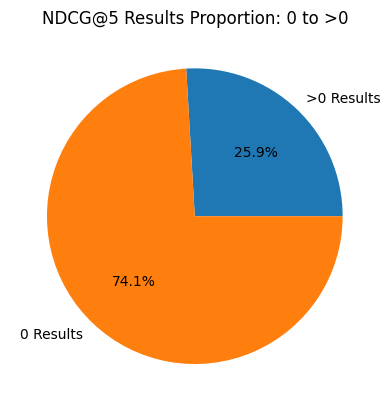

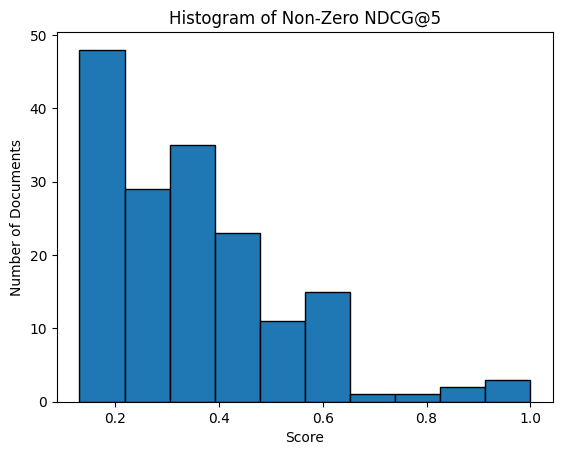

NDCG@5 Mean: 0.09148283798166816 and Std: 0.17920414000477347
NDCG@5 > 0 Mean: 0.3528623750721486 and Std: 0.17787006199949212


In [61]:
# ["contradiction", "entailment"]

utils.present_results(ndcgs_class)

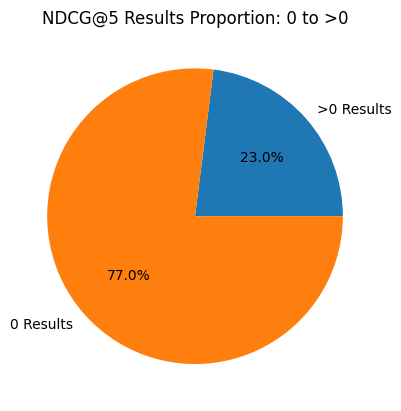

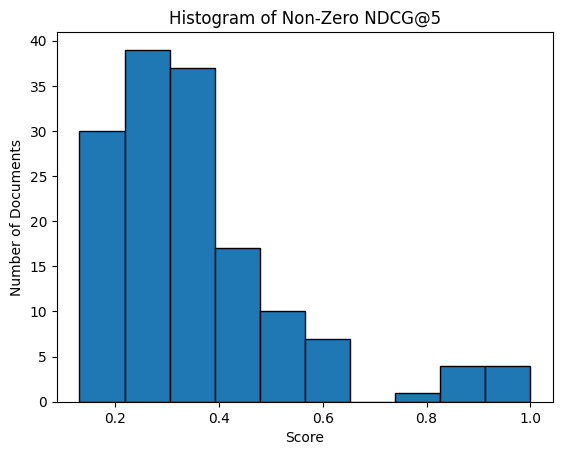

NDCG@5 Mean: 0.08348391939238257 and Std: 0.17688826751946757
NDCG@5 > 0 Mean: 0.3630710051427108 and Std: 0.18592386548105935


In [58]:
# [1, 0]
utils.present_results(ndcgs_class)

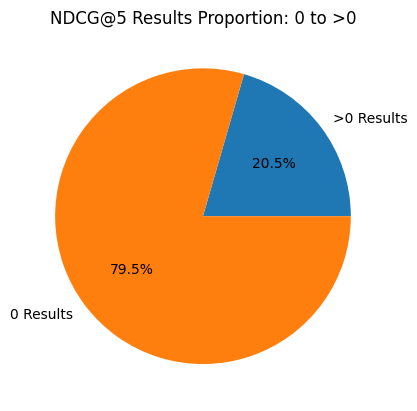

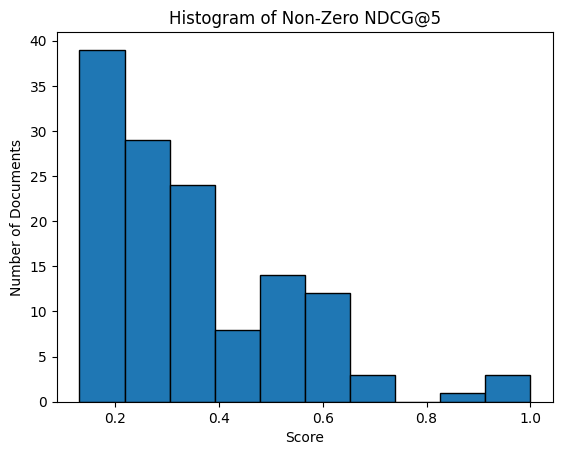

NDCG@5 Mean: 0.07187683877581905 and Std: 0.16552632761342506
NDCG@5 > 0 Mean: 0.3501969287724116 and Std: 0.18980479859734362


In [48]:
# ["positive", "negative"]

utils.present_results(ndcgs_class)

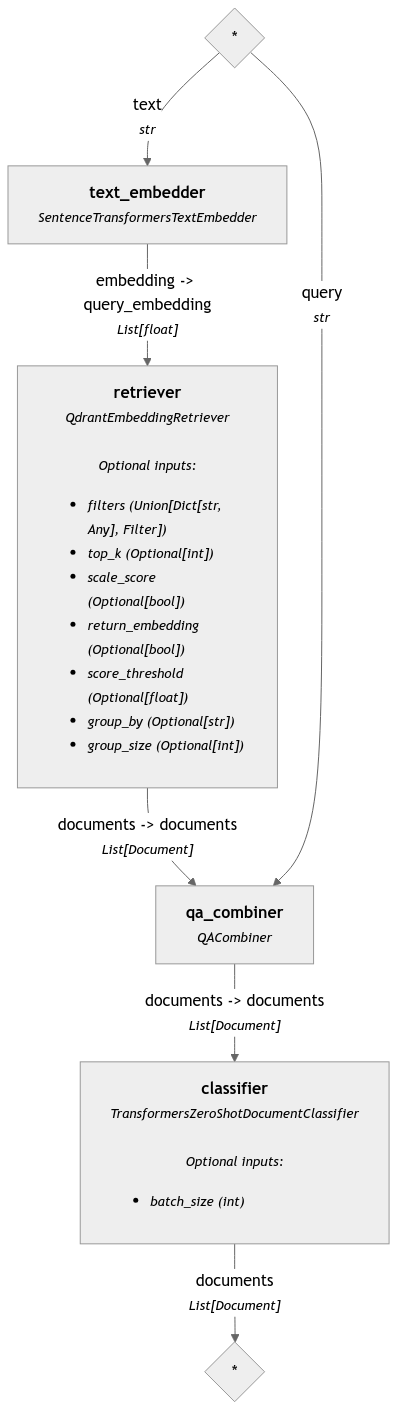

In [45]:
query_pipeline_comb.show()

In [85]:
ndcgs_size = 5

test_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['test'])
test_queries_dict = utils.prepare_fiqa_queries_for_selected_subset(queries, test_query_to_corpus_dict)

query_pipeline_with_classifier = build_query_pipeline_with_classification(document_store, model, "../lab5/best_model_f1_rand")


ndcgs_with_classifier = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline_with_classifier, qeury_data_store_with_classifier, ndcgs_size)

Device set to use mps
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [43]:
#code to reload the lab5_utils file
import importlib
import neural_utils
importlib.reload(neural_utils)

<module 'neural_utils' from '/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/lab8/neural_utils.py'>

Nie można odpalić batch, ponieważ Pipeline dla Haystack >= 2.0 tego nie wspiera

In [ ]:
from haystack.dataclasses.document import Document
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore

document_store = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
)
document_store.write_documents([
    Document(content="This is first", embedding=[0.0]*768),  # 768-dimensional embedding
    Document(content="This is second", embedding=[0.1]*768)  # 768-dimensional embedding

])
print(document_store.count_documents())

100it [00:00, 17015.43it/s]          

2


# Póki co nie działa - do starszej wersji:

In [26]:
from haystack.nodes import EmbeddingRetriever
from haystack.document_stores import InMemoryDocumentStore

doc_store = InMemoryDocumentStore(
    similarity="cosine",  # the e5 models were trained with a cosine similarity function
    embedding_dim=768
)

e5 = EmbeddingRetriever(
    document_store=doc_store,
    embedding_model="intfloat/e5-base-v2",
    model_format="transformers",  # Make sure we specify the transformers model format
    pooling_strategy="reduce_mean",  # This is the pooling method used to train the e5 models
    top_k=20,
    max_seq_len=512,
)
doc_store.update_embeddings(e5)

ImportError: cannot import name 'PipelineSchemaError' from 'haystack.errors' (/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/.venv/lib/python3.12/site-packages/haystack/errors.py)